In [1]:
import SPaCE as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Hahn Echo test

##Make your system of spins
test=sp.spin(50000,method='Uniform',width=1) 
# Main input is the number of spins you want to have in the system. The more spins will make
# it less 'noisy' but takes more time. Width is the frequency range that the spins will resonant
# at in GHz. In this case, the resonant freq is from -0.5 to 0.5 GHz 

##Make the time scale of your pulse sequence and echo
trj=sp.trajectory(1000,2,test)
## These are in the units of ns. Specifically, we are doing 1000 ns length with 2 ns time increments using the 'test' spin system

##Define the pulses
p90=sp.pulse(np.pi/2,30,'rect') #Define as a rectangular pi/2 pulse with a length of 30 ns
p180=sp.pulse(np.pi,60,'rect') #Define a rectangular pi pulse with a length of 60 ns

##Implement the pulses and allow the spins to precess
trj.flip(p90,0,'+x') #pi/2 pulse in the x-direction at time 0
trj.precess(30,330) #precession from t=30 to t=330
trj.flip(p180,330,'+x') #pi pulse in the x-direction at time 330 (300 ns after the first pulse)
trj.precess(390,1000) #precession from t=390 to t=1000
trj.calc_intensity() #Calc intensity based on transition. Only matters with spins of S>1/2. But still needs to be executed for all systems
trj.net_M() #Calculate the net magnetization

In [3]:
pw=sp.pulse(np.pi/2,60,'wurst',6.1,6.5,1000)

Text(0, 0.5, 'Arb Intensity')

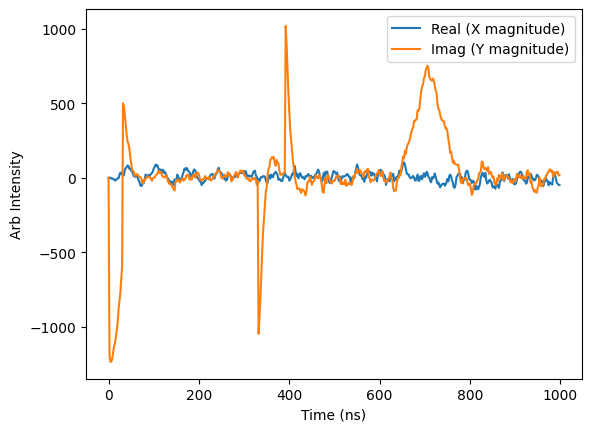

In [4]:
##Plotting only the spins without visualizing the pulses
plt.plot(trj.time,trj.M[0],label='Real (X magnitude)')
plt.plot(trj.time,trj.M[1],label='Imag (Y magnitude)')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Arb Intensity')

Text(0, 0.5, 'Arb Intensity')

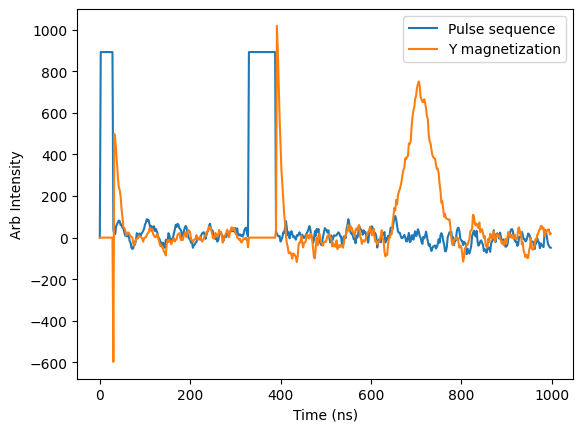

In [5]:
##Plotting with some pulse implementation

#Tell it what pulses are used and where
trj.p_seq([p90,p180],[0,330],['+x','+x'],norm_y=3000000,norm_x=1)
trj.seq[:,0]=np.array([0,0,0])


plt.plot(trj.time,trj.seq[0],label='Pulse sequence')
plt.plot(trj.time,trj.seq[1],label='Y magnetization')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Arb Intensity')

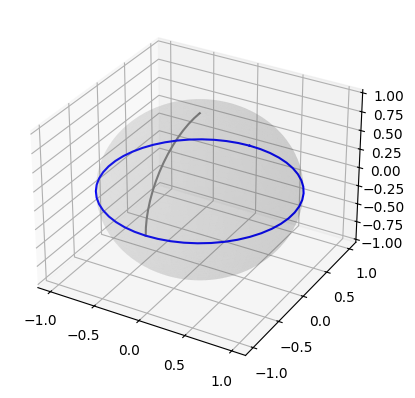

In [6]:
##Visualize with Bloch diagram
trj.display_bloch(0,32,0,'test_central_spin.gif',interval=200)
#The first two inputs are the start and end of trajectory you want to look at while the third input is the frequency of the spin you want to look at. The last two are the filename and the interval (which dicatates the time between 'frames' in ms). Shorter interval makes the animation faster and vice versa

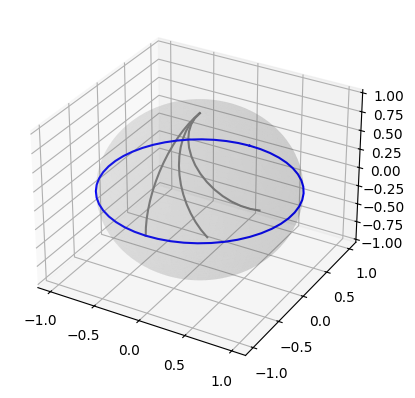

In [7]:
##Visualize with Bloch diagram for multiple spins
trj.display_bloch(0,32,[0,0.005,0.01],'test_mult_spins.gif',interval=200)

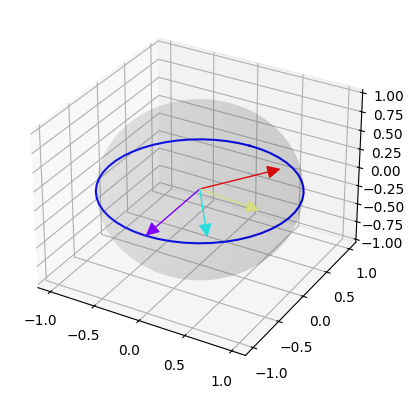

In [8]:
##Visualize with Bloch diagram for multiple spins, as colored arrows
trj.display_bloch(0,32,[0,0.005,0.01, 0.015],'mult_spins_arrow.gif',interval=200,mode='arrow')

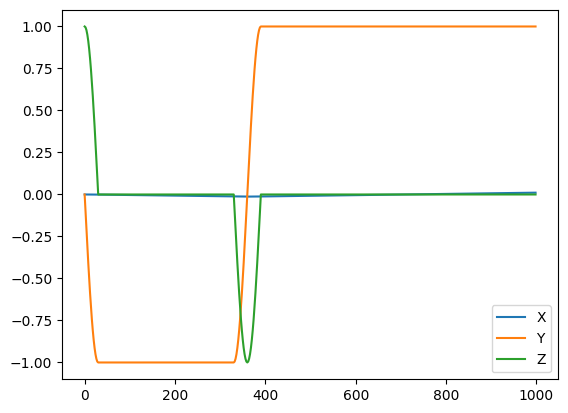

In [9]:
##Extracting the trajectory of a specific spin
central_traj=trj.get_traj(0) #input is only the frequency of spin you are interested in

plt.plot(trj.time,central_traj[0],label='X')
plt.plot(trj.time,central_traj[1],label='Y')
plt.plot(trj.time,central_traj[2],label='Z')
plt.legend()

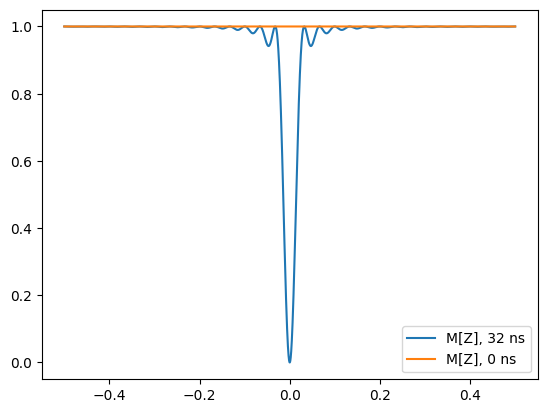

In [10]:
##Visualizing the bandwidth of pulses or the flips of spins across the frequency range

order=np.argsort(trj.nu)#Sort the spins based off of frequency
#The index of trj.traj follows the dimensions of [number of spins, XYZ dimenstion, time point].
#show the Z magnetization (dimension 2) at time 32 ns (data point 16) after the first pi/2 pulse
plt.plot(trj.nu[order],trj.traj[order,2,16], label='M[Z], 32 ns')
#show the Z magnetization (dimension 2) at time 0 ns (data point 0)
plt.plot(trj.nu[order],trj.traj[order,2,0], label='M[Z], 0 ns')
plt.legend(loc='lower right')
plt.show()

In [11]:
## Making a system with sparse spins with specific resonant frequencies
test2=sp.spin(2) #Spin system with only two spins
test2.nu=np.array([0,0.05]) #Set the frequency of the spins

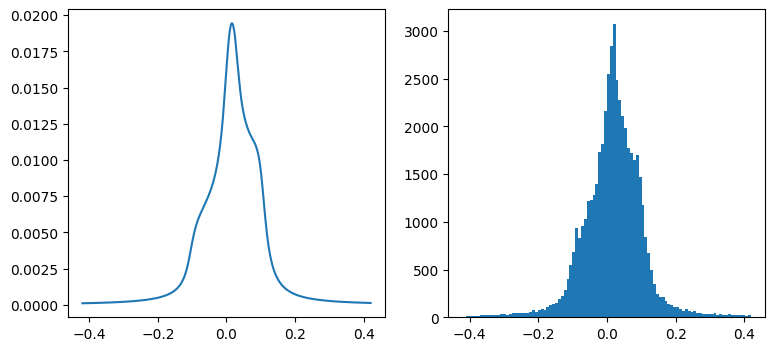

In [12]:
## Making a system with a spectral shape

dist=np.load('Sim_NO.npy')
dist[0]=(dist[0]*2.8-9800)/1000*-1 #super rough calculation of converting field to frequency
#load or make your preferred data structure where the first element of the array is the frequency centered at where you will be pulsing. The second element should just be some intensity.
f,axs = plt.subplots(1,2, figsize=[9,4])
axs[0].plot(dist[0],dist[1]) #Visualize your data input
#input your data to make the spin system using the dist_file argument and the 'Histogram' method option
test3=sp.spin(50000,method='Histogram',dist_file=dist)

#Visualize your spin system with histograms
axs[1].hist(test3.nu,bins=100)
plt.show()

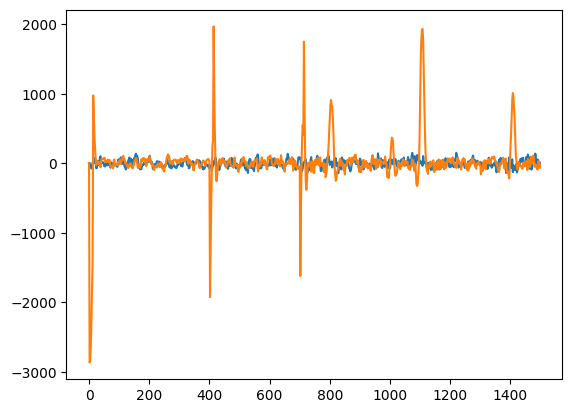

In [14]:
##Complex pulse sequences
#Outside of 2p-hahn-echo, ENDOR, and EDNMR, phase cycling is almost a requirement to identify which echo is the correct one (assuming you don't know which one). Hence, incorporating phase cycles can be done through simple for loops.

#Example of ESEEM without phase-cycle
test4=sp.spin(50000)
trj_eseem=sp.trajectory(1500,2,test4)

p90=sp.pulse(np.pi/2,12,'rect')

trj_eseem.flip(p90,0,'+x')
trj_eseem.precess(12,400)
trj_eseem.flip(p90,400,'+x')
trj_eseem.precess(412,700)
trj_eseem.flip(p90,700,'+x')
trj_eseem.precess(712,1500)
trj_eseem.calc_intensity()
trj_eseem.net_M()

plt.plot(trj_eseem.time,trj_eseem.M[0],label='X')
plt.plot(trj_eseem.time,trj_eseem.M[1],label='Y')

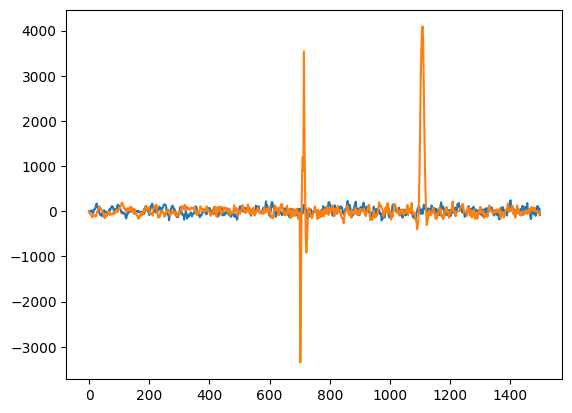

In [ ]:
#Example of ESEEM without phase-cycle

#2-step phase cycle
p3_phases=['+x','-x'] #list of phases of pulse 3
sum_coeff=[1,-1]

#Make array for summing phase cycles
signal=np.zeros((3,750)) #3 dimensions with 750 time points in a 1500 length and 2 ns increments

for i,j in enumerate(p3_phases):
    test4=sp.spin(50000)
    trj_eseem=sp.trajectory(1500,2,test4)

    p90=sp.pulse()
    p90.rect(np.pi/2,12)

    trj_eseem.flip(p90,0,'+x')
    trj_eseem.precess(12,400)
    trj_eseem.flip(p90,400,'+x')
    trj_eseem.precess(412,700)
    trj_eseem.flip(p90,700,j) #change the phase of the pulse based on the phase list
    trj_eseem.precess(712,1500)
    trj_eseem.calc_intensity()
    trj_eseem.net_M()
    signal+=(sum_coeff[i]*trj_eseem.M) #sum the signal with the correct sign on that particular step

plt.plot(trj_eseem.time,signal[0],label='X')
plt.plot(trj_eseem.time,signal[1],label='Y')